<a href="https://colab.research.google.com/github/Gutzu-Encoder/Transfer-Learning/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What are we doing?
task ที่เราจะทำก็คือ segmentation
ก่อนอื่นก็ทำ data preperation ก่อน
เราจะใช้ U-net ทำเเต่เราจะไม่ไล่วางการทำงานของ unet อันนี้เอง เราจะไปเอาตัวที่เป็น pre-trained มาเเทนซึ่งมีการทำงานโดยใช้ u-net
เราจะใช้ ResNet34 encoder เพราะ

-Pretrained on ImageNet (helps generalization)

-Balanced in size vs accuracy

Using it via segmentation_models_pytorch (SMP) keeps code simple and readable.

Note: ในขั้นตอนการ preprocess data คือไอตัว pre-trained กับ dataset เราอาจมี input หรืออะไรไม่ตรงกันทำให้รันไม่ได้ เอาง่ายๆคุยกันคนละภาษา ในขั้นนี้เราจึงต้อง
( ว่าเเต่มีอะไรที่ต้อง concern มั่ง??? ถ้าคิดออกเดี๋ยวมา list ทีหลัง) ปรับให้่มันคุยหันรุ้เรื่องเเต่จะปรับยังไงก้หน้างานเลย ขึ้นกับว่าเราใช้ dataset อะไร เเละ pre-trained อะไร เดะมันรันไม่ได้มันก็ขึ้นเองว่าติดตรงไหน

ในการอ่านอันนี้ขอให้ focus ดูตรงการเอา model ข้างนอกมาใช้มากกว่า

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
from PIL import Image


transform_img = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


transform_mask = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.NEAREST),
    transforms.PILToTensor()
])

class FixedOxfordPet(torch.utils.data.Dataset):
    def __init__(self, root, split="train"):
        self.base_dataset = OxfordIIITPet(
            root=root,
            download=True,
            target_types="segmentation",
            transform=transform_img,
            target_transform=transform_mask
        )

    def __getitem__(self, idx):
        img, mask = self.base_dataset[idx]
        mask = mask.squeeze(0).long() - 1  # <- fix: remove channel + shift values to [0,1,2]
        return img, mask

    def __len__(self):
        return len(self.base_dataset)

dataset = FixedOxfordPet(root='.')


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Number of classes (0 = pet, 1 = border, 2 = background)
num_classes = 3


In [3]:
for _, y in train_dataloader:
    print(torch.unique(y))
    break
#To verify your masks contain only valid class labels.
#tensor([0, 1, 2]) → good! matches your num_classes=3

tensor([0, 1, 2])


In [4]:
from torchvision.transforms import functional as TF

def transform_mask(mask):
    mask = mask.resize((128, 128), resample=Image.NEAREST)
    mask = TF.pil_to_tensor(mask).squeeze(0)  #Converts from PIL image to tensor -> Output shape becomes [1, H, W]
    #squeeze(0) removes the extra channel, so now it's [H, W]
    mask = (mask - 1).clamp(min=0, max=2)     # Force into {0, 1, 2}
    #Original dataset uses values 1, 2, and 3
    #Subtract 1 → now it's {0, 1, 2}
    #Clamp ensures you don't accidentally get -1 or 3 due to weird resampling edges.
    return mask


ทีนี้ต้องเข้าใจก่อนว่าไอตัว pre-trained ถ้ามันอยู่ในโมดูลที่ import มาอยู่เเล้ว เราสามารถทำการเรียกใช้ด้วยการ define ชื่อของ pretrained model ที่จะใช้ในตัว parameter "model" ได้เลย
เเต่ถ้าอย่างอื่นเราอาจจะต้องมีขั้นตอนในการนำเข้าโมเดลนั้นเข้ามาอีกทีก่อน

In [5]:
!pip install segmentation-models-pytorch #โหลด library


In [6]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim


*** This is the important part
note: ถ้าเราจะใช้ตัว pre-trained ที่มีอยู่เเล้วในโมดูลที่ import มาจาก

 from torchvision import models

เราจะเรียกมันมาใช้เลยโดยใช้เป็น class โดยไม่ต้อง import smp มาเพิ่ม (เดี๋ยวหามาใส่ใน reprository) ซึ่งการ freeze/ unfreeze layers มันจะทำได้สะดวกขึ้น

param.requires_grad

If True: it will be updated during training (default).

If False: it won’t be updated — gradients won’t be computed for it.

ถ้าจะ unfreeze มา trainใน layer ที่เราต้องการ

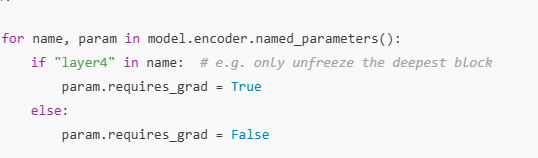



In [7]:
# U-Net with ResNet34 encoder pretrained on ImageNet
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",     # Use ImageNet pretrained weights
    in_channels=3,                  # RGB input
    classes=3                       # Change to match your number of classes
)

# Freeze encoder
for param in model.encoder.parameters():
    param.requires_grad = False


model.to("cuda")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
def train_model(model, dataloader, loss_fn, optimizer, device="cuda"):
    model.train()
    epoch_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.squeeze(1).long()  # ✅ Converts 1xHxW mask to HxW + ensures correct dtype

        preds = model(X)                   # (B, C, H, W)
        loss = loss_fn(preds, y)           # y must be (B, H, W) with class indices

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch % 10 == 0:
            print(f"Batch {batch}, Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch Loss: {avg_loss:.4f}")




In [10]:
epochs = 10  # Number of training epochs

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_model(model, train_dataloader, loss_fn, optimizer, device="cuda")



Epoch 1/10
Batch 0, Loss: 1.5081
Batch 10, Loss: 1.1882
Batch 20, Loss: 0.8554
Batch 30, Loss: 0.8688
Batch 40, Loss: 0.7167
Batch 50, Loss: 0.7385
Batch 60, Loss: 0.6776
Batch 70, Loss: 0.5481
Batch 80, Loss: 0.6056
Batch 90, Loss: 0.5660
Batch 100, Loss: 0.4820
Batch 110, Loss: 0.5881
Batch 120, Loss: 0.5324
Batch 130, Loss: 0.5265
Batch 140, Loss: 0.4915
Batch 150, Loss: 0.4694
Batch 160, Loss: 0.4708
Batch 170, Loss: 0.3621
Batch 180, Loss: 0.4223
Batch 190, Loss: 0.4843
Batch 200, Loss: 0.3938
Batch 210, Loss: 0.4971
Batch 220, Loss: 0.3533
Batch 230, Loss: 0.3885
Batch 240, Loss: 0.4961
Batch 250, Loss: 0.3491
Batch 260, Loss: 0.4782
Batch 270, Loss: 0.3541
Batch 280, Loss: 0.4766
Batch 290, Loss: 0.3715
Batch 300, Loss: 0.3172
Batch 310, Loss: 0.3474
Batch 320, Loss: 0.3678
Batch 330, Loss: 0.2751
Batch 340, Loss: 0.5481
Batch 350, Loss: 0.4503
Batch 360, Loss: 0.4374
Batch 370, Loss: 0.3421
Batch 380, Loss: 0.3712
Batch 390, Loss: 0.3756
Batch 400, Loss: 0.2529
Batch 410, Loss:

In [20]:
# Check unique class labels
for _, y in train_dataloader:
    print(torch.unique(y))
    break


tensor([0, 1, 2])


In [11]:
import matplotlib.pyplot as plt

def visualize_prediction(model, dataloader, device="cuda"):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)  # (B, C, H, W)
            preds = torch.argmax(outputs, dim=1).cpu()  # (B, H, W)

            images = images.cpu()
            masks = masks.squeeze(1).cpu()  # ground truth

            for i in range(len(images)):
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))

                axs[0].imshow(images[i].permute(1, 2, 0))
                axs[0].set_title("Input Image")
                axs[0].axis("off")

                axs[1].imshow(masks[i], cmap="gray")
                axs[1].set_title("Ground Truth Mask")
                axs[1].axis("off")

                axs[2].imshow(preds[i], cmap="gray")
                axs[2].set_title("Predicted Mask")
                axs[2].axis("off")

                plt.tight_layout()
                plt.show()

            break


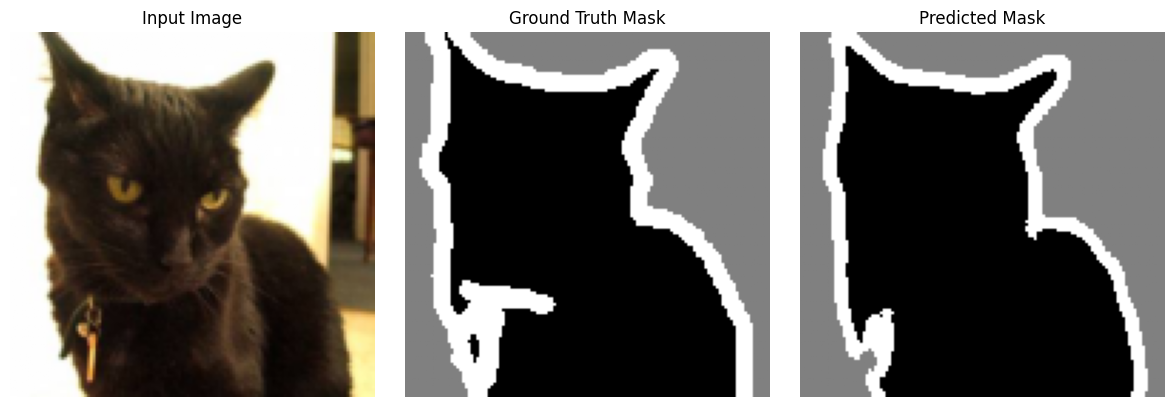

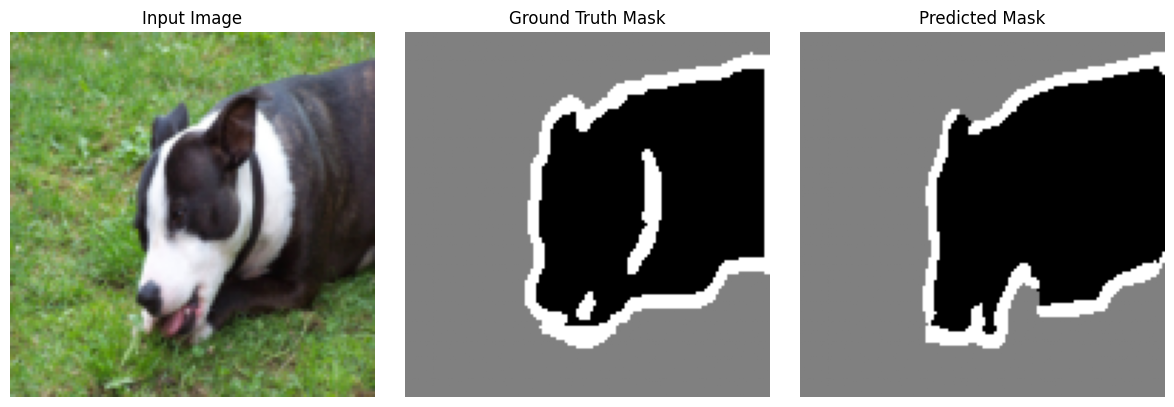

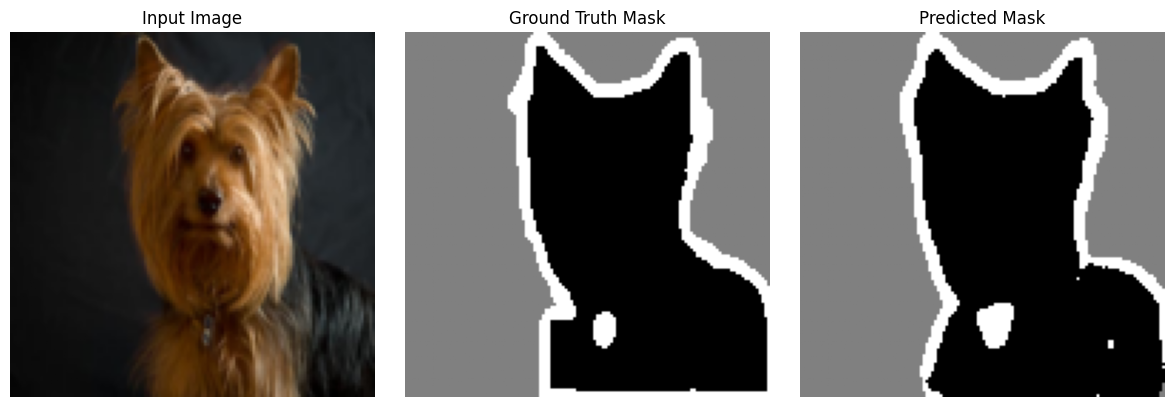

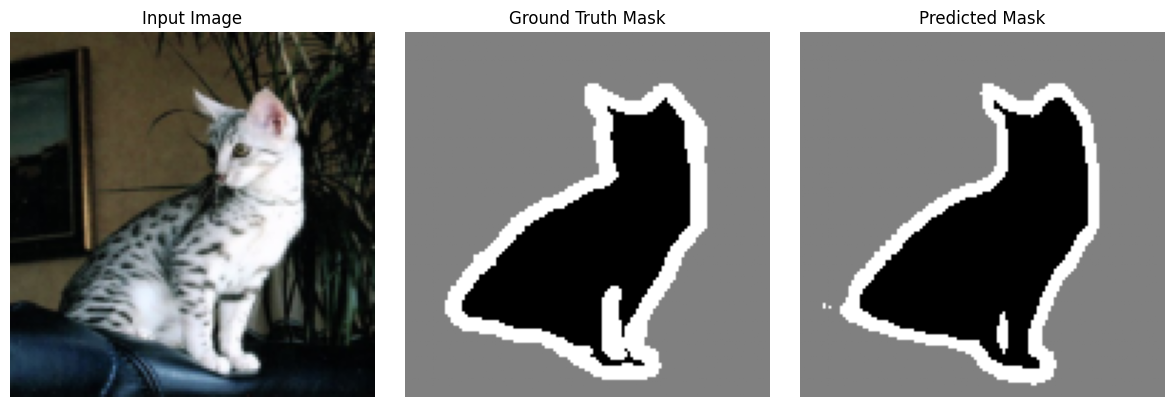

In [12]:
visualize_prediction(model, test_dataloader)
